In [1]:
import seaborn as sns
import pandas as pd
import pandasql as ps
from pathlib import Path
from loguru import logger
import numpy as np
import warnings
import matplotlib.pyplot as plt
import json
import tomllib
import duckdb

warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
# Load configuration and data
configfile = Path("../config.toml").resolve()
with configfile.open("rb") as f:
    config = tomllib.load(f)
datafile = (Path("..") / Path(config["processed"]) / config["current"]).resolve()
if not datafile.exists():
    logger.warning(
        "Datafile does not exist. First run src/preprocess.py, and check the timestamp!"
    )
df = pd.read_parquet(datafile)
df.head()
df.dtypes

timestamp             datetime64[ns, UTC]
message                            object
author                             object
has_emoji                            bool
is_topk                              bool
message_length                      int64
has_link                             bool
timestamp_category               category
hour                               object
day_of_week                         int32
msg_length                          int64
dtype: object

# Example User Stories & Correlations

In [ ]:
print(df.dtypes)


In [3]:

# --- Load metadata ---
with open("nested_users5.json", "r") as f:
    nested_users = json.load(f)

# Convert dictionary to a DataFrame
author_info_df = pd.DataFrame(nested_users).T.reset_index().rename(columns={'index': 'author'})

# --- Merge WhatsApp data with user info ---
df_merged = df.merge(author_info_df, on='author', how='left')

df_merged["mentions_elevator"] = df_merged["message"].str.contains("lift", case=False, na=False)
df_merged.columns

# # --- Aggregate per apartment unit ---
# unit_stats = (
#     df_merged.groupby("Unit_nr")
#              .agg(total_messages=("message", "count"),
#                   avg_msg_length=("msg_length", "mean"),
#                   Entrance_nr=("Entrance_nr", "first"),
#                   Gender=("Gender", "first"),
#                   Floor_nr=("Floor_nr", "first"),
#                   Nr_rooms=("Nr_rooms", "first"))
#              .reset_index()
# )



Index(['timestamp', 'message', 'author', 'has_emoji', 'is_topk',
       'message_length', 'has_link', 'timestamp_category', 'hour',
       'day_of_week', 'msg_length', 'Name', 'Gender', 'Entrance_nr', 'Unit_nr',
       'Floor_nr', 'Nr_rooms', 'mentions_elevator'],
      dtype='object')

In [13]:
# SQL query
# query = "SELECT * FROM df_merged --WHERE playerID = 'albieoz01'"
query = "SELECT * FROM df_merged where mentions_elevator = 1"
result = ps.sqldf(query, locals())
# print(result)
display(result)

,timestamp,message,author,has_emoji,is_topk,message_length,has_link,timestamp_category,hour,day_of_week,msg_length,Name,Gender,Entrance_nr,Unit_nr,Floor_nr,Nr_rooms,mentions_elevator
0,2023-04-08 13:31:22.000000,Iemand zijn vuilniszak vol met vliegen losgela...,silky-lapwing,0,1,60,0,worktimes,13:31:22.000000,5,60,Dylan,Man,1,213,5,3,1
1,2023-05-21 10:00:46.000000,Beneden of lift briefje ophangen?,sudsy-jellyfish,0,1,33,0,worktimes,10:00:46.000000,6,33,Jos Buurman,Man,1,214,5,5,1
2,2023-05-26 20:43:06.000000,Wederom iemand in de lift een vuilniszak met v...,silky-lapwing,0,1,70,0,evening,20:43:06.000000,4,70,Dylan,Man,1,213,5,3,1
3,2023-06-04 12:46:30.000000,Allemaal weer vieze vliegen in de lift!!,flexible-platypus,0,1,40,0,worktimes,12:46:30.000000,6,40,Margreet Lange,Vrouw,1,222,8,3,1
4,2023-06-04 12:51:27.000000,Misschien bestaat de mogelijkheid dat degene d...,intense-toad,0,1,199,0,worktimes,12:51:27.000000,6,199,Herman,Man,1,222,8,5,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129,2025-04-16 12:38:38.000000,"De lift van ingang 1 doet het niet, eerst blee...",bold-bison,0,0,94,0,worktimes,12:38:38.000000,2,94,Cora,Vrouw,1,201,1,3,1
130,2025-05-02 09:29:26.000000,Zie in een hoekje ook dat er wat begint te b...,cheerful-mule,0,1,276,0,worktimes,09:29:26.000000,4,276,Joan Dest,Vrouw,2,232,3,5,1
131,2025-05-19 14:49:54.000000,"Beste allemaal, firma Chex Liftkeuringen komt ...",cackling-eland,0,1,301,0,worktimes,14:49:54.000000,0,301,Maya Sermeno,Vrouw,2,241,6,5,1
132,2025-08-05 09:35:46.000000,10 ook twee voor de lift schachten,silky-lapwing,0,1,34,0,worktimes,09:35:46.000000,1,34,Dylan,Man,1,213,5,3,1


In [14]:
# Query using DuckDB
# salaries.csv is t/m 2016, Albies MLB debut is in 2017, dus jke mist data
# result_duckdb_df_merged = duckdb.query("SELECT * FROM df_merged WHERE playerID = 'balenwl01'").to_df()
# result_duckdb_df_merged = duckdb.query("SELECT * FROM df_merged").to_df()
# print(result_duckdb_df_merged)

In [21]:
floor_stats = (
    df_merged[df_merged["mentions_elevator"]]
    .groupby("Floor_nr")
    .agg(
        elevator_msgs=("message", "count"),
        avg_msg_length=("message_length", "mean"),
        n_authors=("author", "nunique")
    )
    .reset_index()
)

floor_stats.dtypes
floor_stats.head()
floor_stats.count()


Floor_nr          7
elevator_msgs     7
avg_msg_length    7
n_authors         7
dtype: int64

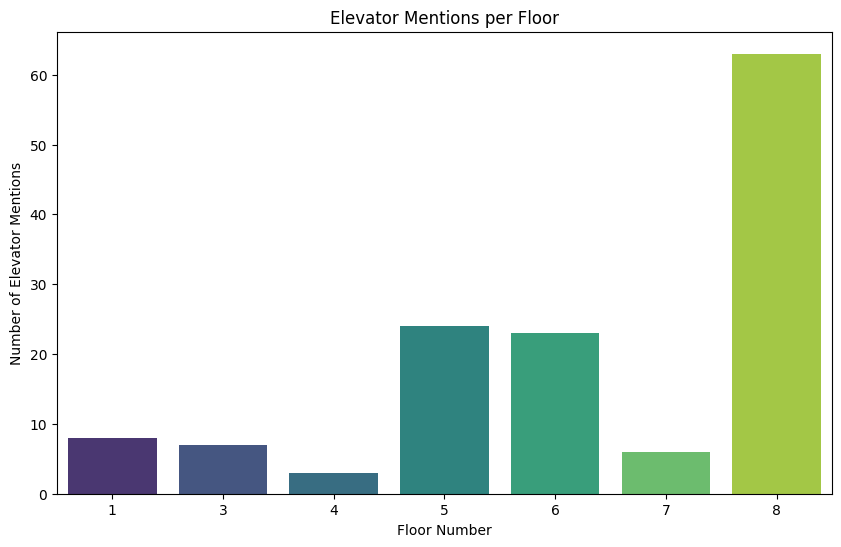

In [ ]:
# Basic relationship: messages mentioning the elevator per floor
plt.figure(figsize=(10, 6))
sns.barplot(data=floor_stats, x="Floor_nr", y="elevator_msgs", palette="viridis")
plt.title("Elevator Mentions per Floor")
plt.xlabel("Floor Number")
plt.ylabel("Number of Elevator Mentions")
plt.show()


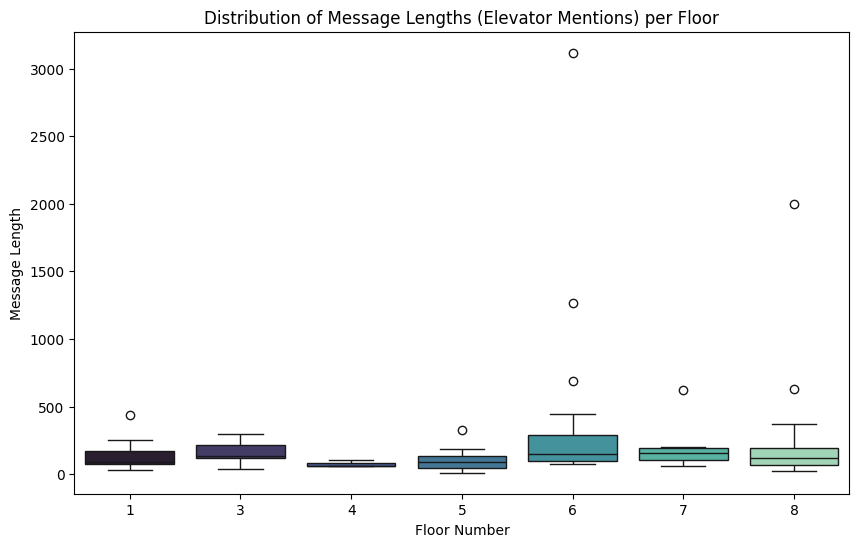

In [ ]:
# Relationship between floor and message length (for elevator-related messages)
plt.figure(figsize=(10, 6))
sns.boxplot(
    data=df_merged[df_merged["mentions_elevator"]],
    x="Floor_nr",
    y="message_length",
    palette="mako"
)
plt.title("Distribution of Message Lengths (Elevator Mentions) per Floor")
plt.xlabel("Floor Number")
plt.ylabel("Message Length")
plt.show()


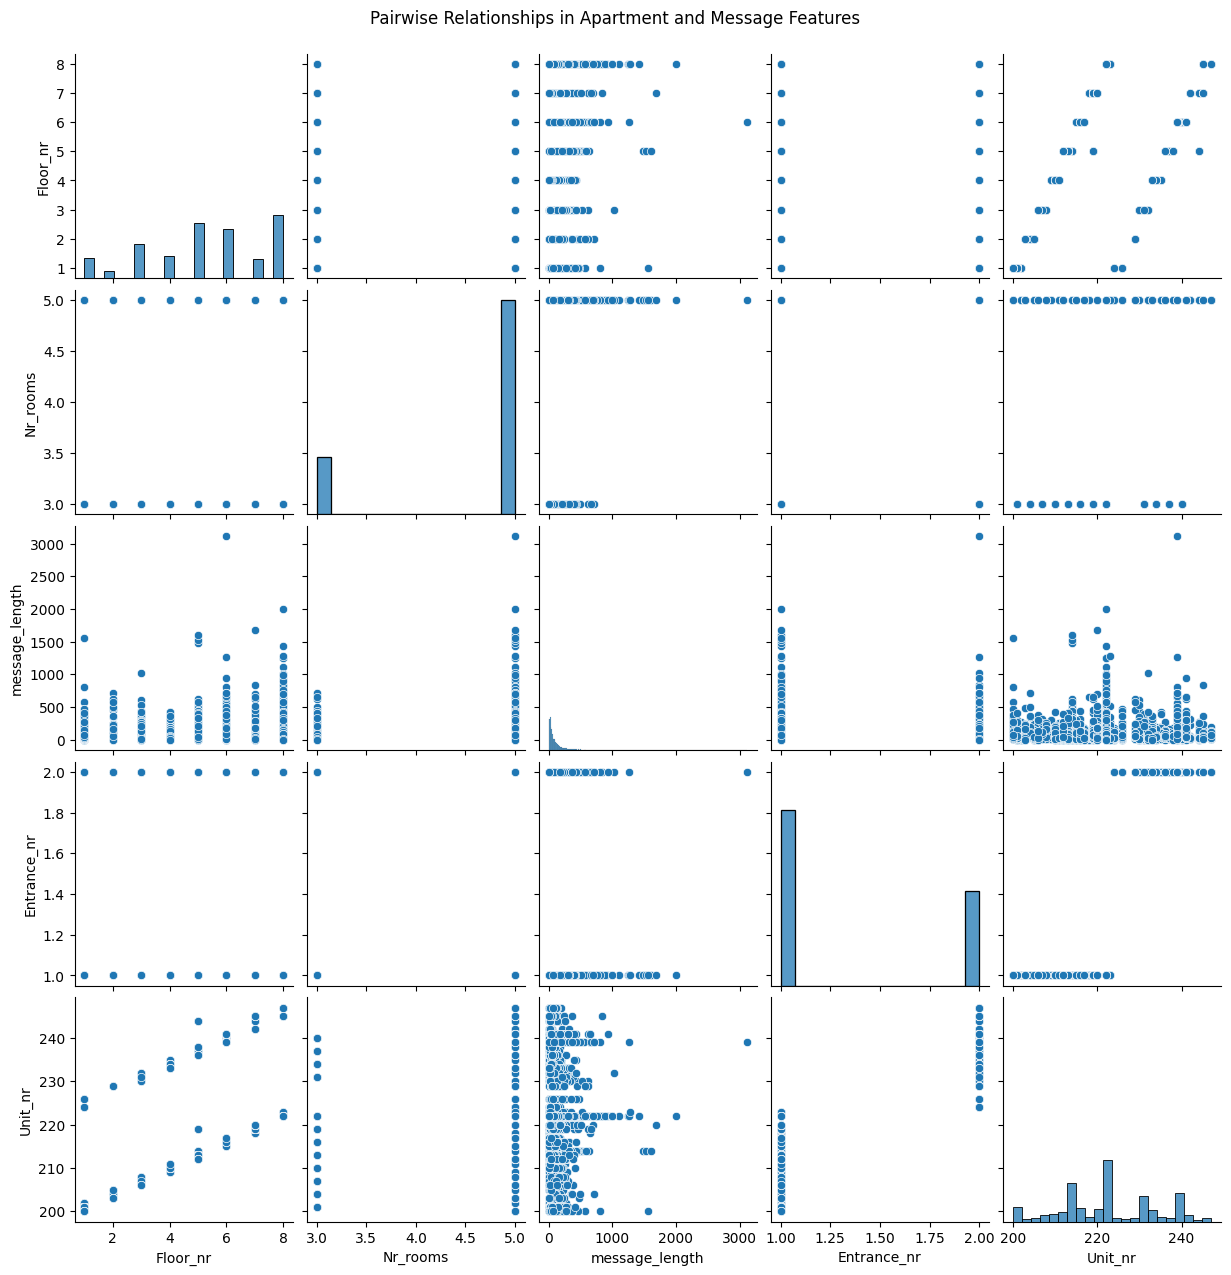

In [23]:
numeric_cols = ["Floor_nr", "Nr_rooms", "message_length", "Entrance_nr", "Unit_nr"]
sns.pairplot(df_merged[numeric_cols].dropna())
plt.suptitle("Pairwise Relationships in Apartment and Message Features", y=1.02)
plt.show()


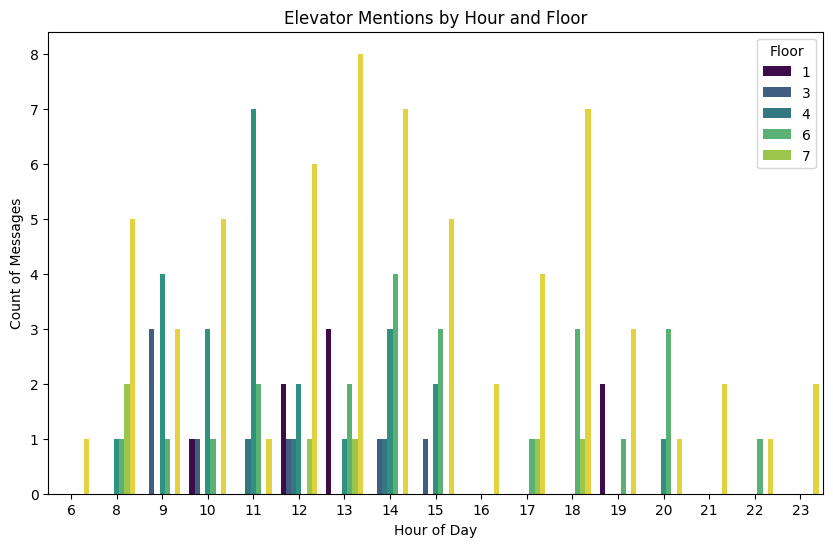

In [24]:
df_merged["hour"] = pd.to_datetime(df_merged["timestamp"]).dt.hour

plt.figure(figsize=(10, 6))
sns.countplot(
    data=df_merged[df_merged["mentions_elevator"]],
    x="hour",
    hue="Floor_nr",
    palette="viridis"
)
plt.title("Elevator Mentions by Hour and Floor")
plt.xlabel("Hour of Day")
plt.ylabel("Count of Messages")
plt.legend(title="Floor")
plt.show()


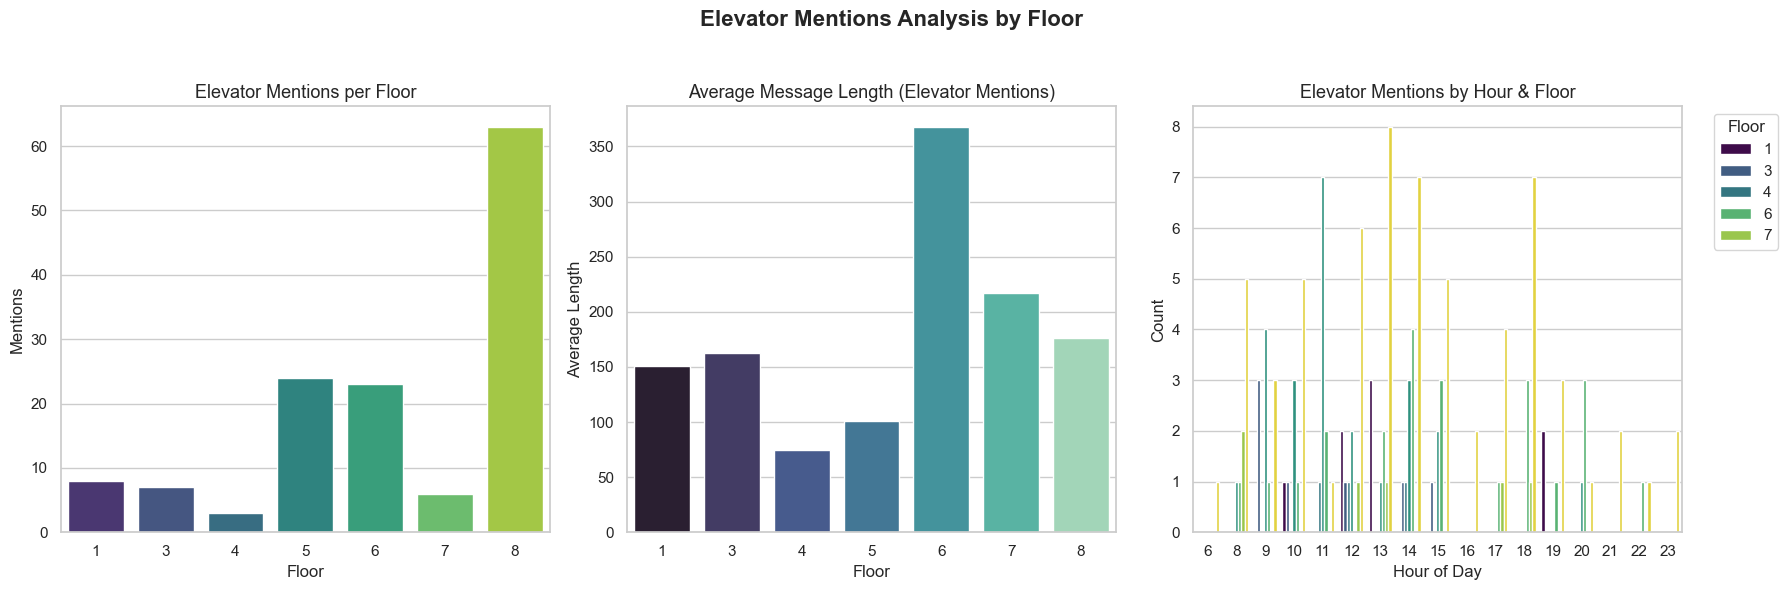

In [25]:
# %%
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# --- Create a flag for elevator mentions ---
df_merged["mentions_elevator"] = df_merged["message"].str.contains("lift", case=False, na=False)

# --- Extract hour for time-based analysis ---
df_merged["hour"] = pd.to_datetime(df_merged["timestamp"]).dt.hour

# --- Aggregate stats per floor ---
floor_stats = (
    df_merged[df_merged["mentions_elevator"]]
    .groupby("Floor_nr")
    .agg(
        elevator_msgs=("message", "count"),
        avg_msg_length=("message_length", "mean"),
        n_authors=("author", "nunique")
    )
    .reset_index()
)

# --- Set style ---
sns.set_theme(style="whitegrid")

# --- Create the figure layout ---
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
plt.suptitle("Elevator Mentions Analysis by Floor", fontsize=16, fontweight="bold")

# --- 1️⃣ Elevator mentions per floor ---
sns.barplot(
    data=floor_stats,
    x="Floor_nr",
    y="elevator_msgs",
    palette="viridis",
    ax=axes[0]
)
axes[0].set_title("Elevator Mentions per Floor", fontsize=13)
axes[0].set_xlabel("Floor")
axes[0].set_ylabel("Mentions")

# --- 2️⃣ Average message length (elevator mentions only) ---
sns.barplot(
    data=floor_stats,
    x="Floor_nr",
    y="avg_msg_length",
    palette="mako",
    ax=axes[1]
)
axes[1].set_title("Average Message Length (Elevator Mentions)", fontsize=13)
axes[1].set_xlabel("Floor")
axes[1].set_ylabel("Average Length")

# --- 3️⃣ Time pattern: hourly elevator mentions ---
sns.countplot(
    data=df_merged[df_merged["mentions_elevator"]],
    x="hour",
    hue="Floor_nr",
    palette="viridis",
    ax=axes[2]
)
axes[2].set_title("Elevator Mentions by Hour & Floor", fontsize=13)
axes[2].set_xlabel("Hour of Day")
axes[2].set_ylabel("Count")
axes[2].legend(title="Floor", bbox_to_anchor=(1.05, 1), loc="upper left")

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


Aggregated statistics per floor:
   Floor_nr  elevator_msgs  avg_msg_length  n_authors
0         1              8      150.500000          5
1         3              7      162.571429          4
2         4              3       75.000000          1
3         5             24      101.208333          4
4         6             23      367.913043          5
5         7              6      217.000000          2
6         8             63      176.126984          5

=== Correlation Analysis ===
Correlation between floor number and elevator mentions: 0.64
Correlation between floor number and average message length: 0.37

=== Regression Analysis ===

Model 1: Elevator Mentions ~ Floor Number
                            OLS Regression Results                            
Dep. Variable:          elevator_msgs   R-squared:                       0.405
Model:                            OLS   Adj. R-squared:                  0.287
Method:                 Least Squares   F-statistic:                 

/Users/luiginocleofa/1_HU_Post_HBO_AI/DAV/MADS-DAV/.venv/lib/python3.12/site-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 7 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
/Users/luiginocleofa/1_HU_Post_HBO_AI/DAV/MADS-DAV/.venv/lib/python3.12/site-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 7 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


Text(0, 0.5, 'Number of Elevator Mentions')

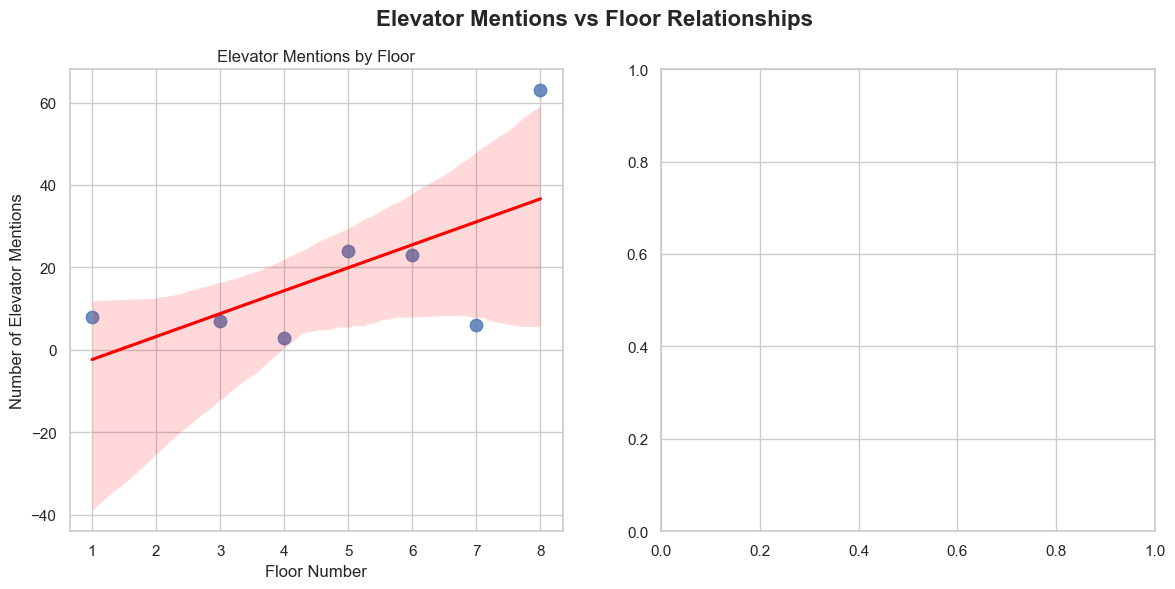

In [29]:
# %%
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from pathlib import Path
import json
import tomllib
from loguru import logger
import warnings

warnings.filterwarnings("ignore", category=FutureWarning)
sns.set_theme(style="whitegrid")

# %%
# --- Load config and data ---
configfile = Path("../config.toml").resolve()
with configfile.open("rb") as f:
    config = tomllib.load(f)

datafile = (Path("..") / Path(config["processed"]) / config["current"]).resolve()
if not datafile.exists():
    logger.warning("Datafile does not exist. First run src/preprocess.py.")
df = pd.read_parquet(datafile)

# --- Load user metadata ---
with open("nested_users5.json", "r") as f:
    nested_users = json.load(f)

author_info_df = (
    pd.DataFrame(nested_users)
    .T.reset_index()
    .rename(columns={"index": "author"})
)

# --- Merge chat data and user info ---
df_merged = df.merge(author_info_df, on="author", how="left")

# %%
# --- Identify elevator-related messages ---
df_merged["mentions_elevator"] = df_merged["message"].str.contains("lift", case=False, na=False)

# --- Extract hour for time analysis ---
df_merged["hour"] = pd.to_datetime(df_merged["timestamp"]).dt.hour

# %%
# --- Aggregate stats per floor ---
floor_stats = (
    df_merged[df_merged["mentions_elevator"]]
    .groupby("Floor_nr")
    .agg(
        elevator_msgs=("message", "count"),
        avg_msg_length=("message_length", "mean"),
        n_authors=("author", "nunique")
    )
    .reset_index()
)

print("Aggregated statistics per floor:")
print(floor_stats)

# %%
# --- Correlation analysis ---
corr_msgs = floor_stats["Floor_nr"].corr(floor_stats["elevator_msgs"])
corr_length = floor_stats["Floor_nr"].corr(floor_stats["avg_msg_length"])

print("\n=== Correlation Analysis ===")
print(f"Correlation between floor number and elevator mentions: {corr_msgs:.2f}")
print(f"Correlation between floor number and average message length: {corr_length:.2f}")

# %%
# --- Regression analysis ---
print("\n=== Regression Analysis ===")

# 1️⃣ Elevator mentions ~ Floor
X1 = sm.add_constant(floor_stats["Floor_nr"])
y1 = floor_stats["elevator_msgs"]
model1 = sm.OLS(y1, X1).fit()

# 2️⃣ Avg message length ~ Floor
y2 = floor_stats["avg_msg_length"]
model2 = sm.OLS(y2, X1).fit()

print("\nModel 1: Elevator Mentions ~ Floor Number")
print(model1.summary())

print("\nModel 2: Avg Message Length ~ Floor Number")
print(model2.summary())

# %%
# --- Visualization ---
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
plt.suptitle("Elevator Mentions vs Floor Relationships", fontsize=16, fontweight="bold")

# 1️⃣ Regression: Elevator Mentions vs Floor
sns.regplot(
    data=floor_stats,
    x="Floor_nr",
    y="elevator_msgs",
    scatter_kws={"s": 80},
    line_kws={"color": "red"},
    ax=axes[0]
)
axes[0].set_title("Elevator Mentions by Floor")
axes[0].set_xlabel("Floor Number")
axes[0].set_ylabel("Number of Elevator Mentions")

# # 2️⃣ Regression: Message Length vs Floor
# sns.regplot(
#     data=floor_stats,
#     x="Floor_nr",
#     y="avg_msg_length",
#     scatter_kws={"s": 80},
#     line_kws={"color": "orange"},
#     ax=axes[1]
# )
# axes[1].set_title("Average Message Length (Elevator Mentions) by Floor")
# axes[1].set_xlabel("Floor Number")
# axes[1].set_ylabel("Average Message Length")

# plt.tight_layout(rect=[0, 0, 1, 0.95])
# plt.show()

# %%
# --- Optional: Combined correlation summary plot ---
# corr_df = pd.DataFrame({
#     "Metric": ["Elevator Mentions", "Avg Message Length"],
#     "Correlation_with_Floor": [corr_msgs, corr_length]
# })

# plt.figure(figsize=(6,4))
# sns.barplot(data=corr_df, x="Metric", y="Correlation_with_Floor", palette="coolwarm")
# plt.title("Correlation of Floor Number with Elevator Message Metrics")
# plt.ylim(-1, 1)
# plt.axhline(0, color="gray", linestyle="--")
# plt.show()


Aggregated statistics per floor:
   Floor_nr  elevator_msgs  avg_msg_length  n_authors
0         1              8      150.500000          5
1         3              7      162.571429          4
2         4              3       75.000000          1
3         5             24      101.208333          4
4         6             23      367.913043          5
5         7              6      217.000000          2
6         8             63      176.126984          5

=== Correlation Analysis ===
Correlation between floor number and elevator mentions: 0.64
Correlation between floor number and average message length: 0.37

=== Regression Analysis ===

Model 1: Elevator Mentions ~ Floor Number
                            OLS Regression Results                            
Dep. Variable:          elevator_msgs   R-squared:                       0.405
Model:                            OLS   Adj. R-squared:                  0.287
Method:                 Least Squares   F-statistic:                 

/Users/luiginocleofa/1_HU_Post_HBO_AI/DAV/MADS-DAV/.venv/lib/python3.12/site-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 7 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


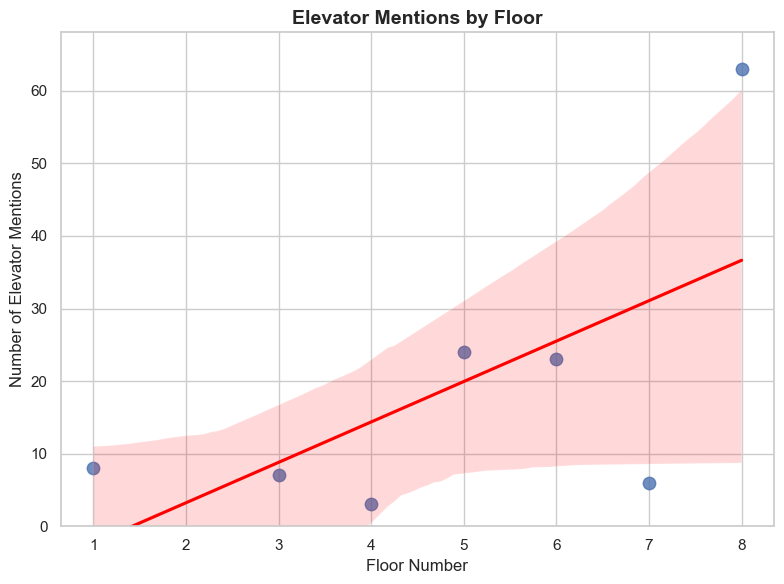

In [33]:
# %%
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from pathlib import Path
import json
import tomllib
from loguru import logger
import warnings

warnings.filterwarnings("ignore", category=FutureWarning)
sns.set_theme(style="whitegrid")

# %%
# --- Load config and data ---
configfile = Path("../config.toml").resolve()
with configfile.open("rb") as f:
    config = tomllib.load(f)

datafile = (Path("..") / Path(config["processed"]) / config["current"]).resolve()
if not datafile.exists():
    logger.warning("Datafile does not exist. First run src/preprocess.py.")
df = pd.read_parquet(datafile)

# --- Load user metadata ---
with open("nested_users5.json", "r") as f:
    nested_users = json.load(f)

author_info_df = (
    pd.DataFrame(nested_users)
    .T.reset_index()
    .rename(columns={"index": "author"})
)

# --- Merge chat data and user info ---
df_merged = df.merge(author_info_df, on="author", how="left")

# %%
# --- Identify elevator-related messages ---
df_merged["mentions_elevator"] = df_merged["message"].str.contains("lift", case=False, na=False)

# --- Extract hour for time analysis ---
df_merged["hour"] = pd.to_datetime(df_merged["timestamp"]).dt.hour

# %%
# --- Aggregate stats per floor ---
floor_stats = (
    df_merged[df_merged["mentions_elevator"]]
    .groupby("Floor_nr")
    .agg(
        elevator_msgs=("message", "count"),
        avg_msg_length=("message_length", "mean"),
        n_authors=("author", "nunique")
    )
    .reset_index()
)

print("Aggregated statistics per floor:")
print(floor_stats)

# %%
# --- Correlation analysis ---
corr_msgs = floor_stats["Floor_nr"].corr(floor_stats["elevator_msgs"])
corr_length = floor_stats["Floor_nr"].corr(floor_stats["avg_msg_length"])

print("\n=== Correlation Analysis ===")
print(f"Correlation between floor number and elevator mentions: {corr_msgs:.2f}")
print(f"Correlation between floor number and average message length: {corr_length:.2f}")

# %%
# --- Regression analysis ---
print("\n=== Regression Analysis ===")

# Elevator mentions ~ Floor
X1 = sm.add_constant(floor_stats["Floor_nr"])
y1 = floor_stats["elevator_msgs"]
model1 = sm.OLS(y1, X1).fit()

print("\nModel 1: Elevator Mentions ~ Floor Number")
print(model1.summary())

# %%
# --- Visualization: Elevator Mentions by Floor ---
plt.figure(figsize=(8, 6))
sns.regplot(
    data=floor_stats,
    x="Floor_nr",
    y="elevator_msgs",
    scatter_kws={"s": 80},
    line_kws={"color": "red"}
)
plt.title("Elevator Mentions by Floor", fontsize=14, fontweight="bold")
plt.xlabel("Floor Number")
plt.ylabel("Number of Elevator Mentions")
plt.ylim(0)
plt.tight_layout()
plt.show()


Aggregated statistics per unit:
    Unit_nr  elevator_msgs  avg_msg_length  n_authors
9       222             56      189.446429          2
6       214             18      109.777778          2
17      239             17      424.352941          2
5       213              5       71.000000          1
10      223              4       48.000000          1
0       200              4      123.500000          1
19      241              3      305.000000          1
18      240              3      111.000000          2
16      233              3       75.000000          1
7       219              3      333.333333          1
8       220              3      100.666667          1
13      230              3      133.333333          1
21      247              2      126.000000          1
15      232              2      159.000000          1
4       212              1       98.000000          1
3       206              1      295.000000          1
2       202              1       30.000000        

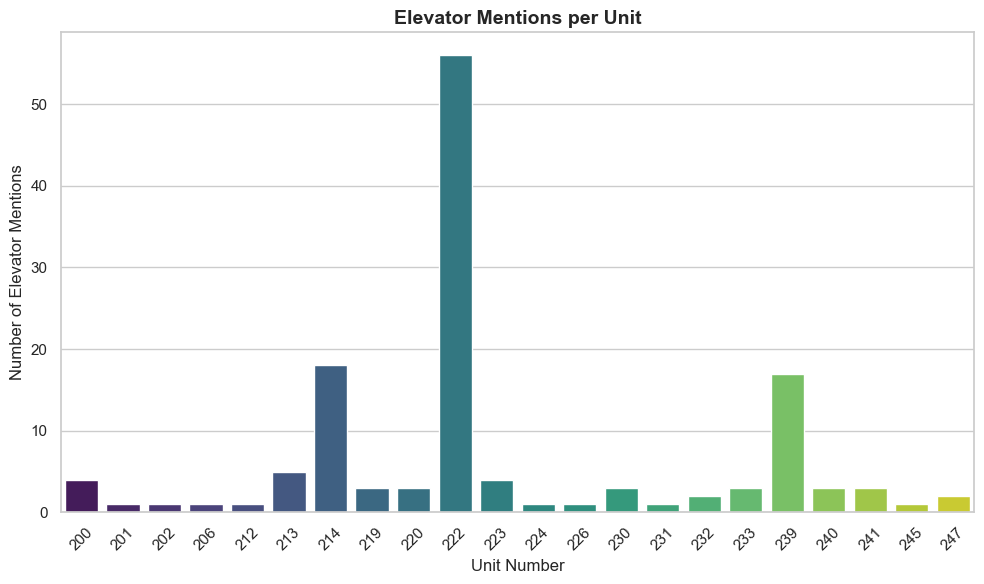

In [31]:
# %%
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from pathlib import Path
import json
import tomllib
from loguru import logger
import warnings

warnings.filterwarnings("ignore", category=FutureWarning)
sns.set_theme(style="whitegrid")

# %%
# --- Load config and data ---
configfile = Path("../config.toml").resolve()
with configfile.open("rb") as f:
    config = tomllib.load(f)

datafile = (Path("..") / Path(config["processed"]) / config["current"]).resolve()
if not datafile.exists():
    logger.warning("Datafile does not exist. First run src/preprocess.py.")
df = pd.read_parquet(datafile)

# --- Load user metadata ---
with open("nested_users5.json", "r") as f:
    nested_users = json.load(f)

author_info_df = (
    pd.DataFrame(nested_users)
    .T.reset_index()
    .rename(columns={"index": "author"})
)

# --- Merge chat data and user info ---
df_merged = df.merge(author_info_df, on="author", how="left")

# %%
# --- Identify elevator-related messages ---
df_merged["mentions_elevator"] = df_merged["message"].str.contains("lift|elevator", case=False, na=False)

# %%
# --- Aggregate stats per Unit ---
unit_stats = (
    df_merged[df_merged["mentions_elevator"]]
    .groupby("Unit_nr")
    .agg(
        elevator_msgs=("message", "count"),
        avg_msg_length=("message_length", "mean"),
        n_authors=("author", "nunique")
    )
    .reset_index()
    .sort_values("elevator_msgs", ascending=False)
)

print("Aggregated statistics per unit:")
print(unit_stats)

# %%
# --- Correlation (optional, if you want relation with floor or size) ---
# corr_units = unit_stats["Unit_nr"].corr(unit_stats["elevator_msgs"])
# print(f"\nCorrelation between unit number and elevator mentions: {corr_units:.2f}")

# %%
# --- Visualization: Elevator Mentions by Unit ---
plt.figure(figsize=(10, 6))
sns.barplot(
    data=unit_stats,
    x="Unit_nr",
    y="elevator_msgs",
    palette="viridis"
)
plt.title("Elevator Mentions per Unit", fontsize=14, fontweight="bold")
plt.xlabel("Unit Number")
plt.ylabel("Number of Elevator Mentions")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Aggregated statistics per unit:
    Unit_nr  Floor_nr  elevator_msgs  avg_msg_length  n_authors
9       222         8             56      189.446429          2
6       214         5             18      109.777778          2
17      239         6             17      424.352941          2
5       213         5              5       71.000000          1
10      223         8              4       48.000000          1
0       200         1              4      123.500000          1
19      241         6              3      305.000000          1
18      240         6              3      111.000000          2
16      233         4              3       75.000000          1
7       219         7              3      333.333333          1
8       220         7              3      100.666667          1
13      230         3              3      133.333333          1
21      247         8              2      126.000000          1
15      232         3              2      159.000000          1
4       

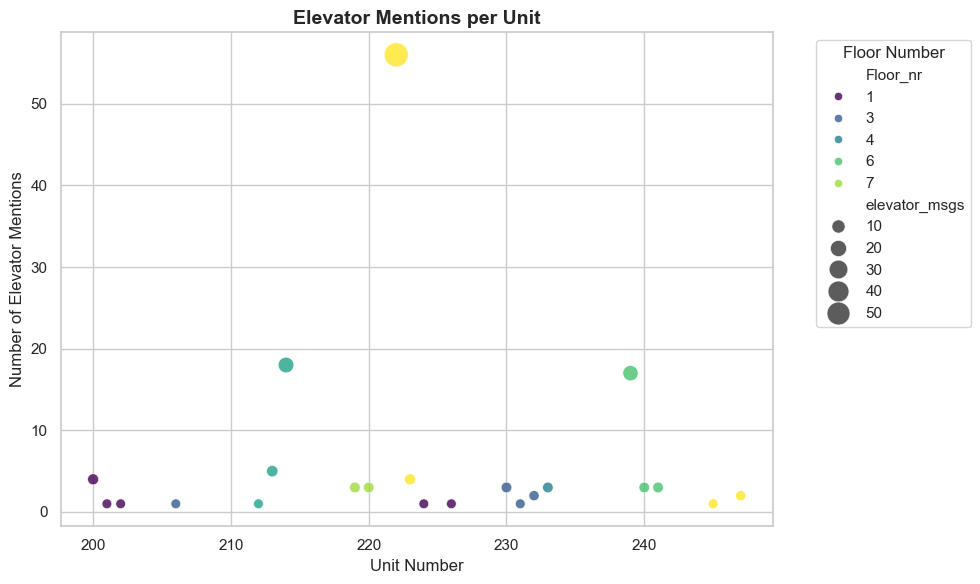

In [32]:
# %%
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
import json
import tomllib
from loguru import logger
import warnings

warnings.filterwarnings("ignore", category=FutureWarning)
sns.set_theme(style="whitegrid")

# %%
# --- Load config and data ---
configfile = Path("../config.toml").resolve()
with configfile.open("rb") as f:
    config = tomllib.load(f)

datafile = (Path("..") / Path(config["processed"]) / config["current"]).resolve()
if not datafile.exists():
    logger.warning("Datafile does not exist. First run src/preprocess.py.")
df = pd.read_parquet(datafile)

# --- Load user metadata ---
with open("nested_users5.json", "r") as f:
    nested_users = json.load(f)

author_info_df = (
    pd.DataFrame(nested_users)
    .T.reset_index()
    .rename(columns={"index": "author"})
)

# --- Merge chat data and user info ---
df_merged = df.merge(author_info_df, on="author", how="left")

# %%
# --- Identify elevator-related messages ---
df_merged["mentions_elevator"] = df_merged["message"].str.contains("lift|elevator", case=False, na=False)

# %%
# --- Aggregate stats per Unit ---
unit_stats = (
    df_merged[df_merged["mentions_elevator"]]
    .groupby(["Unit_nr", "Floor_nr"])
    .agg(
        elevator_msgs=("message", "count"),
        avg_msg_length=("message_length", "mean"),
        n_authors=("author", "nunique")
    )
    .reset_index()
    .sort_values("elevator_msgs", ascending=False)
)

print("Aggregated statistics per unit:")
print(unit_stats)

# %%
# --- Visualization: Scatter Plot ---
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=unit_stats,
    x="Unit_nr",
    y="elevator_msgs",
    hue="Floor_nr",          # color-coded by floor
    size="elevator_msgs",    # bubble size by number of mentions
    sizes=(50, 300),
    palette="viridis",
    alpha=0.8
)

plt.title("Elevator Mentions per Unit", fontsize=14, fontweight="bold")
plt.xlabel("Unit Number")
plt.ylabel("Number of Elevator Mentions")
plt.legend(title="Floor Number", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()
